# Day-night artefacts

In the plots where we visualize the evolution of the fractal dimension, we can observe a daily oscillation in the signal. Take, for example, the plot we obtained for patient 4, shown below.

We see a rise in fractal dimension when the end of the 3-day window is positioned at midnight. To explain why these daily artefacts occur, we will visualize the activity counts for one of these windows: the 3-day window for which the fractal dimension indicated by the arrow is obtained (the artefact), ending on 02/04 at 0:00, and the 3-day window ending 12 hours after that. 

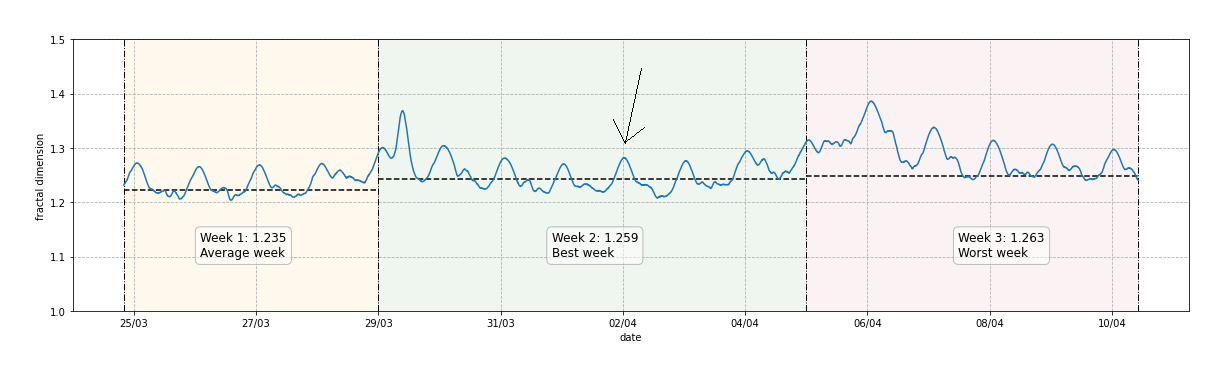

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

from lib import helpers
from lib import complexity

In [2]:
patient_id = 4
df = helpers.read_counts(patient_id)

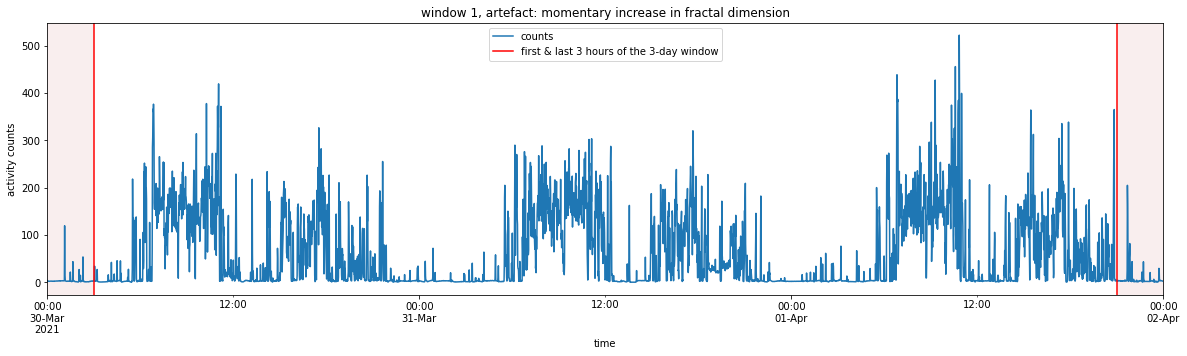

In [40]:
df["2021-03-30 0:00":"2021-04-02 0:00"]["counts"].plot(figsize=(20,5))
plt.axvspan(datetime.datetime.strptime("2021-03-30 0:00", "%Y-%m-%d %H:%M"), datetime.datetime.strptime("2021-03-30 03:00", "%Y-%m-%d %H:%M"), facecolor="indianred", alpha=0.1)
plt.axvspan(datetime.datetime.strptime("2021-04-02 0:00", "%Y-%m-%d %H:%M"), datetime.datetime.strptime("2021-04-01 21:00", "%Y-%m-%d %H:%M"), facecolor="indianred", alpha=0.1)
plt.axvline(x=datetime.datetime.strptime("2021-03-30 03:00", "%Y-%m-%d %H:%M"), color = 'red', label="first & last 3 hours of the 3-day window") 
plt.axvline(x=datetime.datetime.strptime("2021-04-01 21:00", "%Y-%m-%d %H:%M"), color = 'red')
plt.ylabel("activity counts")
plt.xlabel("time")
plt.title("window 1, artefact: momentary increase in fractal dimension")
plt.legend()
plt.show()

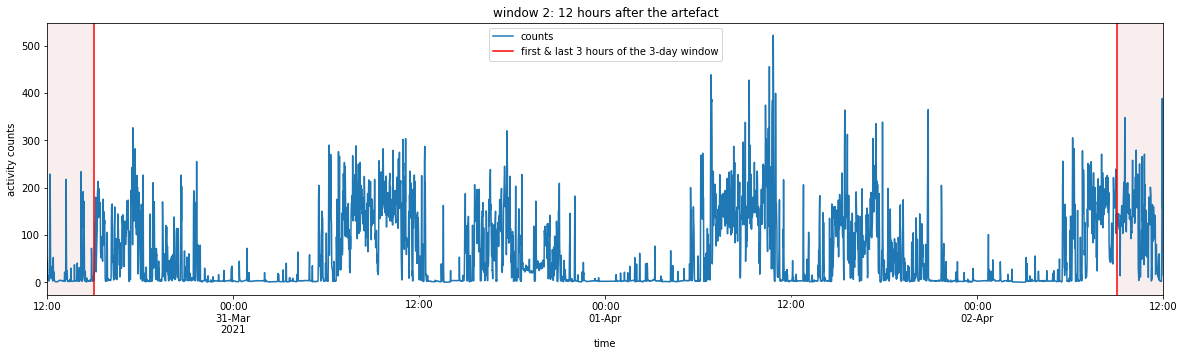

In [41]:
df["2021-03-30 12:00":"2021-04-02 12:00"]["counts"].plot(figsize=(20,5))
plt.axvspan(datetime.datetime.strptime("2021-03-30 12:00", "%Y-%m-%d %H:%M"), datetime.datetime.strptime("2021-03-30 15:00", "%Y-%m-%d %H:%M"), facecolor="indianred", alpha=0.1)
plt.axvspan(datetime.datetime.strptime("2021-04-02 12:00", "%Y-%m-%d %H:%M"), datetime.datetime.strptime("2021-04-02 09:00", "%Y-%m-%d %H:%M"), facecolor="indianred", alpha=0.1)
plt.axvline(x=datetime.datetime.strptime("2021-03-30 15:00", "%Y-%m-%d %H:%M"), color = 'red', label="first & last 3 hours of the 3-day window") 
plt.axvline(x=datetime.datetime.strptime("2021-04-02 09:00", "%Y-%m-%d %H:%M"), color = 'red')
plt.ylabel("activity counts")
plt.xlabel("time")
plt.title("window 2: 12 hours after the artefact")
plt.legend()
plt.show()

In the plots above, we show patient 4's counts sequence for two 3-day windows, the first one starting on 30/03 at 0:00 and ending on 02/04 at 0:00, the second one starting on 30/03 at 12:00 and ending on 02/04 at 12:00. Calculating the fractal dimension for the first window results in the peak indicated with the arrow in the evolution plot. The fractal dimension for the second window will be considerably lower, as can also be seen on the evolution plot. 

Consider the step of the adapted allometric aggregation method where n equals to 3 times 60 (equivalent to a scale of 3 hours), in which the counts in the sequence are aggregated into overlapping segments of 3 hours wide. Some counts at the start and at the end of the considered 3-day window will be part of less overlapping segments than the counts situated in the middle of the window. When the mean and variance of the resulting segments is calculated, these samples at the edges effectively receive less weight in the calculation, because they contribute to a lower fraction of the segments. 

In the example shown, the red lines indicate the first and last 3 hours of the window. Samples that fall within the red zones, are part of the set of samples which receive less weight in the calculation of the mean and variance. In the case of the second 3-day window (the bottom figure), these samples don't contain particularly diverging values compared to the other samples which are present between the red lines. However, in the case of the first window (the top figure), a large part of the sleeping period falls within the problematic areas. Such a sleeping period contains samples representing much lower counts (usually very close to zero). Because these samples are not weighed properly, the variance is underestimated, resulting in a higher fractal dimension. The fractal dimension will reduce once the sleep period is not for the largest part contained at the start and at the end of the window anymore. This will occur for the second window, which has advanced 12 hours further and where all sleeping periods fall somewhere outside of the red zones. 

This day-night artefact is not necessarily a huge problem, since it is clear why it occurs, and it will appear regularly every day, as long as the subject's sleep pattern is relatively regular too. This seems to be the case for this patient, otherwise the sleeping periods for current day and 3 days previously would not line up as well as they do here, inducing the artefact. 

We will now plot the mean-variance relation obtained for these two windows, to show that the fractal dimension is indeed higher for the first window. We slightly change the adapted_allometric_aggregation algorithm, so that it also returns the means and variances extracted from the sequence. 

In [24]:
import numpy.polynomial.polynomial as poly
# version of the AAA method which returns the estimated means and variances
def adapted_allometric_aggregation(seq, n_min, n_max, s=1.1, draw=True):
    """
    The adapted allometric aggregation algorithm. Returns the fractal dimension of a time series for various scales 
    and the log-log plot from which these were extracted. We draw attention to the changes that were made compared to the original
    allometric aggregation algorithm in the comments. 

    :param seq: numpy array of equidistant signal values, in our case 1-minute activity counts sequence
    :param n_min: minimal level of aggregation
    :param n_max: maximal level of aggregation
    :param s: factor controlling the spread of the aggregation levels within the interval [n_min, n_max], default value 1.1
    :param draw: a boolean indicating whether or not to draw the log-log plot and the estimated polynomial, default value True

    return: the fractal dimension of the sequence (float) for every level n in scales
    """

    means = []
    variances = []
    scales = []
    n = n_min # the first aggregation step aggregates n_min samples
    
    while n <= n_max:

        step = max(1, int(n/16)) # some overlap is now allowed in the aggregated segments of size n
                                    # if step would be equal to n, we would allow no overlap like in the original AA algorithm
                                    # now, step is at least 16 times smaller than n, generating 16 times more segments 
                                    # (now partially overlapping) to estimate mean and var from
        rescaled = []
        i = 0
        
        while i < len(seq)-n+step: # every segment always contains n samples, except for the last one, which contains at least 15/16*n samples
                                    # this ensures a reliable calculation of the mean and variance, avoiding end effects
            agg = sum(seq[i:i+n])
            rescaled.append(agg)
            i += step # sliding window moves forward with steps smaller than n, allowing the segments to overlap
        
        means.append(np.mean(rescaled))
        variances.append(np.var(rescaled))
        scales.append(n) # keep track of the scales we explored within the interval [n_min, n_max]
        
        n = int(np.ceil(n*s)) # increase aggregation level n with factor s to ensure even spreading of the 
                                # mean-variance datapoints on the log-log plot
                                # this makes the fit of the polynomial better adjusted to all scales, rather than biased towards the higher scales

    means = np.array(means)
    variances = np.array(variances)

    # fit third-order polynomial to the means and variances in log-log space
    fitted_poly = poly.Polynomial.fit(np.log(means), np.log(variances), 3)
    coeff = fitted_poly.convert().coef

    # draw fitted polynomial
    if (draw):
        fig, ax = plt.subplots(1)
        plt.scatter(means, variances)
        plt.plot(means, np.exp(coeff[0]+coeff[1]*np.log(means)+coeff[2]*np.log(means)**2+coeff[3]*np.log(means)**3), color='red')
        ax.set_yscale("log")
        ax.set_xscale("log")
        plt.xlabel("mean")
        plt.ylabel("variance")
    
    # calculate fractal dimension for every scale in "scales", by obtaining the derivative of the polynomial (which represents the local slope)
    slopes = coeff[1] + 2*coeff[2]*np.log(means) + 3*coeff[3]*np.log(means)**2
    D = 2 - slopes / 2 
    
    return D, np.array(scales), means, variances # the dimension on index i of "D" corresponds to the scale on index i of "scales"

In [36]:
window1 = df["2021-03-30 0:00":"2021-04-02 0:00"]["counts"]
fract_dim1, scales, means1, variances1  = adapted_allometric_aggregation(np.array(window1), 1, 9*60, draw=False)

In [37]:
window2 = df["2021-03-30 12:00":"2021-04-02 12:00"]["counts"]
fract_dim2, scales, means2, variances2  = adapted_allometric_aggregation(np.array(window2), 1, 9*60, draw=False)

In [28]:
fract_dim1[35] # fractal dimension on a scale of 3 hours

1.2804929649262018

In [29]:
fract_dim2[35] # fractal dimension on a scale of 3 hours

1.2192985977323065

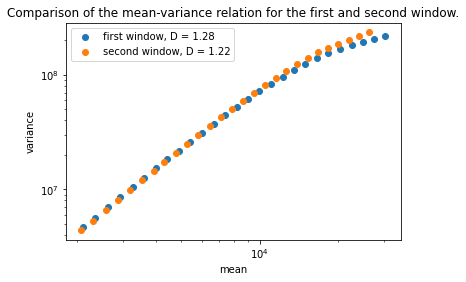

In [38]:
fig, ax = plt.subplots(1)
plt.scatter(means1[20:], variances1[20:], label="first window, D = 1.28")
plt.scatter(means2[20:], variances2[20:], label="second window, D = 1.22")
plt.legend()
ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("mean")
plt.ylabel("variance")
plt.title("Comparison of the mean-variance relation for the first and second window.")
plt.show()

The slope obtained for the first window (for higher scales) is lower than the one obtained for the second window. This means that a higher fractal dimension will be obtained for the first window than for the second. This confirms that the variance is underestimated for that window, due to the inbalanced weighing of the 3-hour segments containing the sleeping periods at the start and at the end of the window. 